In [1]:
# MET CS 767 - Machine Learning - Final Project
# Prasad Kothpalli
# Stock Price Prediction Problem Using XGBoost  Method
# Loading and Handling Data into pandas using Libraries

In [31]:
# This is a LSTM NN model to predict Stock prices for NASDAQ and Interntional Stocks
# Thsi is going to demonstrate LSTM using stackable layers of LSTMs
# import pandas and other libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from sklearn import preprocessing 

In [32]:
# import Yahoo finance library

In [33]:
from pandas_datareader import data as pdr #extract data from internet sources into pandas data frame
import yfinance as yf

yf.pdr_override()
start_date = "2014-02-13"
end_date = "2020-03-20"
stocks = 'FB'
df = pdr.get_data_yahoo(stocks, start = start_date, end = end_date )
dataset = df [['Open', 'High', 'Low', 'Close']]
dataset.head(2)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close
Date,,,,
2014-02-13,64.18,67.330002,64.050003,67.330002
2014-02-14,67.50,67.580002,66.720001,67.089996


In [34]:
# Choose randon reproducebility 
np.random.seed(101)
 
dataset = dataset.reindex(index = dataset.index[::-1])

# Creating own  Obserbvations   for  use
obs = np.arange(1, len(dataset) + 1, 1)

#  Taking OHLC, HLC and close value indicators for prediction
 
OHLC_avg = dataset.mean(axis = 1)
HLC_avg = dataset[['High', 'Low', 'Close']].mean(axis = 1)
close_val = dataset[['Close']]

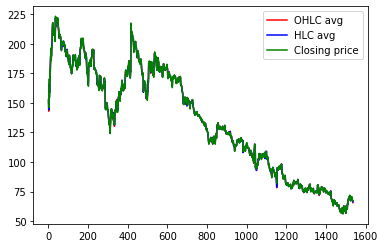

In [35]:
#Plot the graph with above indicators 

plt.plot(obs, OHLC_avg, 'r', label = 'OHLC avg')
plt.plot(obs, HLC_avg, 'b', label = 'HLC avg')
plt.plot(obs, close_val, 'g', label = 'Closing price')
plt.legend(loc = 'upper right')

plt.show()

In [36]:
# Stacked LSTM Model  implementation 
# data set function takes data set and returns a Time series data as  array with t and t+ step_size 

def new_dataset(dataset, step_size):
    trainX, trainY = [], []
    for i in range(len(dataset)-step_size-1):
        a = dataset[i:(i+step_size), 0]
        trainX.append(a)
        trainY.append(dataset[i + step_size, 0])
    return np.array(trainX), np.array(trainY)

# Prepartaion of Time series Dataset
# Applying Normalization before feeding to LSTM using Sklearn
# MinMaxScaler works by shrinking range of values into 0 and 1

OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg),1)) 
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_avg = scaler.fit_transform(OHLC_avg)

# Prepare Train and Test Sets  

train_OHLC = int(len(OHLC_avg) * 0.85) #3155
test_OHLC = len(OHLC_avg) - train_OHLC #1353
train_OHLC, test_OHLC = OHLC_avg[0:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]

In [42]:
# Time_series Dataset  (FOR TIME T, VALUES FOR TIME T+1)
trainX, trainY = new_dataset(train_OHLC, 1)
testX, testY = new_dataset(test_OHLC, 1)

In [43]:
# Reshaping train and Test data as a 3 D array to be passed  to LSTM 
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
step_size = 1

In [44]:
testX.shape

(229, 1, 1)

In [45]:
# LSTM MODEL  for Stacked Implementation

model = Sequential()
# Output of hidden state of neuron is used as an input to the next LSTM layer
model.add(LSTM(units = 128, input_shape=(1, step_size), return_sequences = True))
#
model.add(Dropout(0.1))
# Output of hidden state of neuron is used as an input to the next LSTM layer
model.add(LSTM(units = 64, return_sequences = True))
model.add(Activation('softmax'))
model.add(Dropout(0.1))
model.add(LSTM(units = 32 ,return_sequences = False))
model.add(Dense(units = 8))
model.add(Activation('relu'))
# Dense layer which acts as the output model of the layer
model.add(Dense(units = 1))
model.add(Activation('linear'))

# MODEL COMPILING AND TRAINING

model.compile(loss='mean_squared_error', optimizer='adam') # Try SGD, adam, adagrad and compare!!!

#Print model Summary
print(model.summary())
history = model.fit(trainX, trainY, epochs=500, validation_data = (testX, testY ), batch_size=4, verbose=0, shuffle = False) # Epochs = 50
 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 1, 128)            66560     
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 128)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 1, 64)             49408     
_________________________________________________________________
activation_4 (Activation)    (None, 1, 64)             0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 64)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_3 (Dense)              (None, 8)                

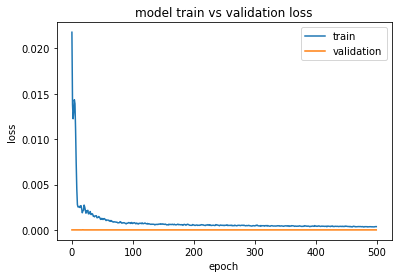

In [110]:
# plot train and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [111]:
# Predictions on train and test data are as follws
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [112]:
# DE-NORMALIZING FOR PLOTTING - Scale Bcak for normal Plotting
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [113]:
# TRAINING RMSE with results 
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train RMSE: %.2f' % (trainScore))

Train RMSE: 27.46


In [114]:
# TEST RMSE
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))

Test RMSE: 1.56


In [115]:
# RMSE of test > RMSE of train => OVER FITTING of the data.
# RMSE of test < RMSE of train => UNDER FITTING of the data.
# adagrad - 50 epochs - 0.75 - Train 0.01 - Test -0.02
# adam - 50 epochs - 0.75 - Train 0.01 - Test -0.01
# SGD - 50 epochs - 0.75 - Train 0.01 - Test -0.01
# SGD - 100 epochs - 0.75 - Train 2.49 - Test 1.05
# Adam - 100 epochs - 0.75 - Train 3.24 - Test 2.78 ( units = 50,25, 1)
# Adam - 100 epochs - 0.75 - Train 2.61 - Test 1.67 ( units = 32,16, 1) - FB
# Adam - 150 epochs - 0.75 - Train 2.57 - Test 1.58 ( units = 32,16, 1)
# Adam - 50 epochs - 0.75 - Train 2.87 - Test 6.18 ( units = 32,16, 1)
# Adam - 100 epochs - 0.75 - Train 0.64 - Test 0.45 ( units = 32,16, 1) - TTM
# Adam - 100 epochs - 0.75 - Train 3.55 - Test 0.99 ( units = 32,16, 1) - NFLX
# Adam - 100 epochs - 0.67 - Train 4.24 - Test 0.98 ( units = 32,16, 1) - NFLX
# Adam - 100 epochs - 0.85 - Train 3.18 - Test 1.09 ( units = 32,16, 1) - NFLX
# Adam - 100 epochs - 0.90 - Train 3.44 - Test 0.520 ( units = 32,16,8, 1 - first layer) - NFLX
# Adam - 50 epochs - 0.67 - Train 3.7 - Test 0.152 ( units = 32,16,8, 1 - first layer) - NFLX
# Adam - 50 epochs - 0.67 - Train 3.7 - Test 0.152 ( units = 32,16,8, 1 - first layer) - NFLX
# Adam - 50 epochs - 0.70 - Train 3.7 - Test 0.152 ( units = 50,25,5,1 - first layer) - NFLX
# Adam - 50 epochs - 0.70 - Train 4.14 - Test 3.03 ( units = 50,50,25,5,1 - first layer) - NFLX - Drop 0.1

# Adam - 50 epochs - 0.70 - Train 3.74 - Test 2.08 ( units = 50,50,25,1 - first layer) - NFLX - Linear 

# Adam - 50 epochs - 0.70 - Train 155.74 - Test 2.63 ( units = 50,50,25,1 - first layer) - NFLX - ReLU 
# Adam - 50 epochs - 0.70 - Train 3.77 - Test 2.30 ( units = 50,50,25,1 - first layer) - NFLX - Linear 
# Adam - 50 epochs - 0.70 - Train 4.33 - Test 1.82 ( units = 50,50,25,1 - first layer) - NFLX - Linear  - Bi-drectional 1l
# Adam - 50 epochs - 0.70 - Train 4.97 - Test 0.35 ( units = 50,50,25,1 - first layer) - NFLX - Linear  - Bi-drectional 2l

# Adam - 50 epochs - 0.70 - Train 3.90 - Test 2.05 ( units = 50,25,12,1 - first layer) - NFLX - Linear  - Bi-drectional 3l
# Adam - 50 epochs - 0.70 - Train 3.52 - Test 2.02 ( units = 50,50,25,1 - 3 layers) - NFLX - Linear  - Bi-drectional
# Adam - 50 epochs - 0.70 - Train 47.56 - Test 1.29 ( units = 100,50,25,1 - 3 layers) - NFLX - Linear  - stack

In [116]:
# CREATING SIMILAR DATASET TO PLOT TRAINING PREDICTIONS
trainPredictPlot = np.empty_like(OHLC_avg)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size, :] = trainPredict

In [117]:
# CREATING SIMILAR DATASSET TO PLOT TEST PREDICTIONS
testPredictPlot = np.empty_like(OHLC_avg)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+1:len(OHLC_avg)-1, :] = testPredict

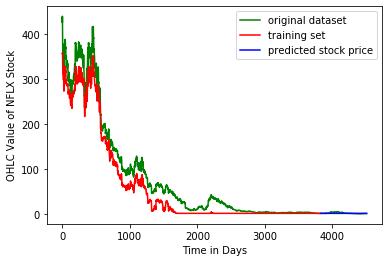

In [118]:
# DE-NORMALIZING MAIN DATASET 
OHLC_avg = scaler.inverse_transform(OHLC_avg)

# PLOT OF MAIN OHLC VALUES, TRAIN PREDICTIONS AND TEST PREDICTIONS
plt.plot(OHLC_avg, 'g', label = 'original dataset')
plt.plot(trainPredictPlot, 'r', label = 'training set')
plt.plot(testPredictPlot, 'b', label = 'predicted stock price')
plt.legend(loc = 'upper right')
plt.xlabel('Time in Days')
plt.ylabel('OHLC Value of NFLX Stock')
plt.show()

In [119]:
# PREDICT FUTURE VALUES
last_val = trainPredict[1]

In [120]:
last_val

array([355.85477], dtype=float32)

In [121]:
last_val_scaled = last_val/last_val
next_val = model.predict(np.reshape(last_val_scaled, (1,1,1)))
print ("Last Day Value:", np.asscalar(last_val))
print ("Next Day Value:", np.asscalar(last_val*next_val))
#print np.append(last_val, next_val)

Last Day Value: 355.8547668457031
Next Day Value: 289.472412109375


/share/pkg.7/python3/3.6.9/install/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  This is separate from the ipykernel package so we can avoid doing imports until
/share/pkg.7/python3/3.6.9/install/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  after removing the cwd from sys.path.


In [1]:
!nvidia-smi


/usr/bin/sh: nvidia-smi: command not found


In [2]:
!echo $CUDA_VISIBLE_DEVICES